## Segmenting and Clustering Neighborhoods in Toronto

### Task 1 : Web scraping and Data Wrangling

In [1]:
import pandas as pd
import numpy as np

import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# scraping
import requests # library to handle requests
from urllib.request import urlopen
import lxml.html as lh

# geocoders
from geopy.geocoders import Nominatim

# visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
#!conda install -c conda-forge folium=0.5.0
#!conda install -c districtdatalabs yellowbrick
import folium  # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


#### Scraping Wikipedia page, creating Pandas Dataframe

In [2]:
# credits : https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059
# codes below allows us to get the Neigbourhod & Postal codes data of the HTML table

import lxml.html as lh
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

# parse the first row as our header
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    print('%d: "%s"'%(i,name))
    col.append((name,[]))

1: "Postcode"
2: "Borough"
3: "Neighbourhood
"


In [3]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not table data we want 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
        
# check the length of each column. Ideally, they should all be the same.
[len(C) for (title,C) in col]

[287, 287, 287]

In [4]:
# create the DataFrame
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)
# remove newlines
df = df.replace('\n','', regex=True)

In [5]:
df.head(10)

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Queen's Park,Not assigned


#### Cleaning data

In [6]:
#dropping the "Not Assigned" borough
df = df[df.Borough != 'Not assigned']
df = df.sort_values(by=['Postcode','Borough'])

df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)
df.head(10)

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,Rouge
1,M1B,Scarborough,Malvern
2,M1C,Scarborough,Highland Creek
3,M1C,Scarborough,Rouge Hill
4,M1C,Scarborough,Port Union
5,M1E,Scarborough,Guildwood
6,M1E,Scarborough,Morningside
7,M1E,Scarborough,West Hill
8,M1G,Scarborough,Woburn
9,M1H,Scarborough,Cedarbrae


In [7]:
#Consolidating the neighbourhoods that share the postcode

df_postcodes = df['Postcode']
df_postcodes.drop_duplicates(inplace=True)
df1 = pd.DataFrame(df_postcodes)
df1['Borough'] = '';
df1['Neighbourhood'] = '';


df1.reset_index(inplace=True)
df1.drop('index', axis=1, inplace=True)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

for i in df1.index:
    for j in df.index:
        if df1.iloc[i, 0] == df.iloc[j, 0]:
            df1.iloc[i, 1] = df.iloc[j, 1]
            df1.iloc[i, 2] = df1.iloc[i, 2] + ', ' + df.iloc[j, 2]
            
for i in df1.index:
    s = df1.iloc[i, 2]
    if s[0] == ',':
        s =s [1:]
    df1.iloc[i,2 ] = s
    
df1.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
print('There are {} rows in the dataframe.'.format(df.shape[0]))

There are 210 rows in the dataframe.


### Task 2 : Get Coordinates

In [9]:
#reading the file to coord dataframe
df1['Latitude'] = '0';
df1['Longitude'] = '0';

coord = pd.read_csv('https://cocl.us/Geospatial_data')

In [10]:
#merging dataframe that contain coordinates with the one that contains borough names
for i in df1.index:
    for j in coord.index:
        if df1.iloc[i, 0] == coord.iloc[j, 0]:
            df1.iloc[i, 3] = coord.iloc[j, 1]
            df1.iloc[i, 4] = coord.iloc[j, 2]

#checking the results            
df1.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.8067,-79.1944
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.7845,-79.1605
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.7636,-79.1887
3,M1G,Scarborough,Woburn,43.771,-79.2169
4,M1H,Scarborough,Cedarbrae,43.7731,-79.2395


### Task 3 : Data Analysis

In [11]:
# Select neighbourhoods that contain word " Downtown Toronto":
toronto = df1[df1['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.6796,-79.3775
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.668,-79.3677
2,M4Y,Downtown Toronto,Church and Wellesley,43.6659,-79.3832
3,M5A,Downtown Toronto,Harbourfront,43.6543,-79.3606
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.6572,-79.3789


In [12]:
#get the coordinates for Toronto
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ca_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [13]:
#create the Folium map of Downtown Toronto
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto['Latitude'], toronto['Longitude'], toronto['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [14]:
CLIENT_ID = '5B2QEMNKLC4BMRBRSZ3GOCNJ5ACQRGKOSF2IQ401XDDXVSMX'#'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'TGCYT4XYBARBNC4VLYRV2MI2NG221OD2QTKJMXVWW4PFYUBL'#'your-client-secret' # your Foursquare Secret
VERSION = '20200105' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: 5B2QEMNKLC4BMRBRSZ3GOCNJ5ACQRGKOSF2IQ401XDDXVSMX
CLIENT_SECRET:TGCYT4XYBARBNC4VLYRV2MI2NG221OD2QTKJMXVWW4PFYUBL


In [15]:
# Get the neighborhood's name.
toronto.loc[0, 'Neighbourhood']

' Rosedale'

In [16]:
#Get the neighborhood's latitude and longitude values.
neighborhood_latitude = toronto.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of  Rosedale are 43.6795626, -79.37752940000001.


#### Get the top 100 venues that are in Downtown Toronto within a radius of 500 meters (using Foursquare API)

In [17]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=5B2QEMNKLC4BMRBRSZ3GOCNJ5ACQRGKOSF2IQ401XDDXVSMX&client_secret=TGCYT4XYBARBNC4VLYRV2MI2NG221OD2QTKJMXVWW4PFYUBL&v=20200105&ll=43.6795626,-79.37752940000001&radius=500&limit=100'

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
# run the above function on each neighborhood and create a new dataframe called downtown_venues
LIMIT = 100 # limit of number of venues returned by Foursquare API

downtown_venues = getNearbyVenues(names=toronto['Neighbourhood'],
                                   latitudes=toronto['Latitude'],
                                   longitudes=toronto['Longitude']
                                  )

 Rosedale
 Cabbagetown, St. James Town
 Church and Wellesley
 Harbourfront
 Ryerson, Garden District
 St. James Town
 Berczy Park
 Central Bay Street
 Adelaide, King, Richmond
 Harbourfront East, Toronto Islands, Union Station
 Design Exchange, Toronto Dominion Centre
 Commerce Court, Victoria Hotel
 Harbord, University of Toronto
 Chinatown, Grange Park, Kensington Market
 CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
 Stn A PO Boxes 25 The Esplanade
 First Canadian Place, Underground city
 Christie
 Queen's Park


In [20]:
#checking the size of venues dataframe
print('{} venues were returned by Foursquare.'.format(downtown_venues.shape[0]))

1306 venues were returned by Foursquare.


In [21]:
#check on nos of unique categories under venues
print('There are {} unique categories.'.format(len(downtown_venues['Venue Category'].unique())))

There are 206 unique categories.


In [22]:
downtown_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",18,18,18,18,18,18
"Cabbagetown, St. James Town",44,44,44,44,44,44
Central Bay Street,79,79,79,79,79,79
"Chinatown, Grange Park, Kensington Market",84,84,84,84,84,84
Christie,18,18,18,18,18,18
Church and Wellesley,83,83,83,83,83,83
"Commerce Court, Victoria Hotel",100,100,100,100,100,100


####  Analyze Each Neighborhood

In [23]:
# one hot encoding
dwnT_onehot = pd.get_dummies(downtown_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
dwnT_onehot['Neighbourhood'] = downtown_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [dwnT_onehot.columns[-1]] + list(dwnT_onehot.columns[:-1])
dwnT_onehot = dwnT_onehot[fixed_columns]

dwnT_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rosedale,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#checking the dataframe size
dwnT_onehot.shape

(1306, 207)

In [25]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
dwnT_grouped = dwnT_onehot.groupby('Neighbourhood').mean().reset_index()
dwnT_grouped.head(10)

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.0,...,0.0,0.0,0.00,0.020000,0.0,0.000000,0.010000,0.000000,0.01,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.00,0.018182,0.0,0.000000,0.000000,0.000000,0.00,0.000000
2,"CN Tower, Bathurst Quay, Island airport, Harb...",0.000000,0.055556,0.055556,0.055556,0.111111,0.166667,0.111111,0.000000,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000
3,"Cabbagetown, St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.0,...,0.0,0.0,0.00,0.012658,0.0,0.000000,0.012658,0.000000,0.00,0.012658
5,"Chinatown, Grange Park, Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.00,0.047619,0.0,0.071429,0.011905,0.000000,0.00,0.000000
6,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000
7,Church and Wellesley,0.012048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012048,0.0,...,0.0,0.0,0.00,0.000000,0.0,0.012048,0.000000,0.012048,0.00,0.012048
8,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.0,...,0.0,0.0,0.00,0.020000,0.0,0.000000,0.010000,0.000000,0.00,0.000000
9,"Design Exchange, Toronto Dominion Centre",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.0,...,0.0,0.0,0.01,0.010000,0.0,0.000000,0.010000,0.000000,0.00,0.000000


In [26]:
#checking the grouped dataframe size
dwnT_grouped.shape

(19, 207)

#### Print each neighbourhood along with the top 5 most common venues

In [27]:
num_top_venues = 5

for hood in dwnT_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = dwnT_grouped[dwnT_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Adelaide, King, Richmond----
            venue  freq
0     Coffee Shop  0.07
1      Steakhouse  0.04
2            Café  0.04
3  Cosmetics Shop  0.03
4      Restaurant  0.03


---- Berczy Park----
          venue  freq
0   Coffee Shop  0.07
1  Cocktail Bar  0.05
2        Bakery  0.04
3    Steakhouse  0.04
4          Café  0.04


---- CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0   Airport Service  0.17
1    Airport Lounge  0.11
2  Airport Terminal  0.11
3   Harbor / Marina  0.06
4           Airport  0.06


---- Cabbagetown, St. James Town----
         venue  freq
0         Café  0.07
1  Coffee Shop  0.07
2         Park  0.05
3          Pub  0.05
4       Bakery  0.05


---- Central Bay Street----
                venue  freq
0         Coffee Shop  0.15
1                Café  0.05
2  Italian Restaurant  0.05
3      Ice Cream Shop  0.04
4        Burger Joint  0.04


---- Chinatown, Grange Park,

#### Converting the results to Pandas dataframe:

In [28]:
#function to sort the venues in descending order:

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [29]:
#create the new dataframe and display the top 10 venues for each neighborhood:

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = dwnT_grouped['Neighbourhood']

for ind in np.arange(dwnT_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dwnT_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bakery,Bar,Cosmetics Shop,Restaurant,Asian Restaurant,Thai Restaurant,Concert Hall
1,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Seafood Restaurant,Farmers Market,Bakery,Steakhouse,Café,French Restaurant
2,"CN Tower, Bathurst Quay, Island airport, Harb...",Airport Service,Airport Lounge,Airport Terminal,Boat or Ferry,Coffee Shop,Sculpture Garden,Boutique,Rental Car Location,Bar,Plane
3,"Cabbagetown, St. James Town",Café,Coffee Shop,Italian Restaurant,Pub,Restaurant,Bakery,Park,Pizza Place,Plaza,Pharmacy
4,Central Bay Street,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Juice Bar,Japanese Restaurant,Burger Joint,Ice Cream Shop,Gym / Fitness Center,Department Store


#### Find optimal k for k-means clustering
"Neighbourhood" in this dataset is a categorical variable, k-means algorithm isn't directly applicable to categorical variables.

In [30]:
# We shall drop this variable "Neighbourhood"

dwnT_grouped_cluster = dwnT_grouped.drop('Neighbourhood', axis=1)

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


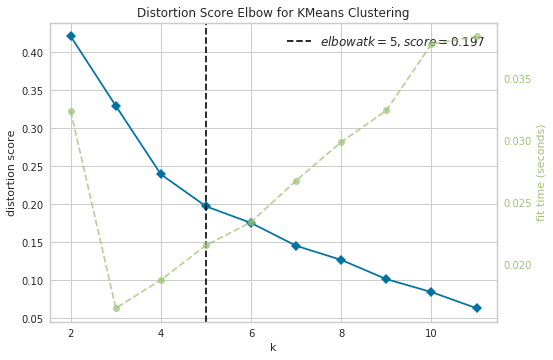

In [31]:
# Below is a plot of sum of squared distances for k in the range specified above. If the plot looks like an arm, then the elbow on the arm is optimal k

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,12))

visualizer.fit(dwnT_grouped_cluster)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In the plot above, optimal k for this dataset is seen at the elbow, which k=5

#### Cluster Neighbourhoods
Run k-means to cluster the neighborhood into 5 clusters.

In [32]:
# set number of clusters
kclusters = 5

#dwnT_grouped_clustering = dwnT_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dwnT_grouped_cluster)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 3, 2, 2, 2, 4, 2, 2, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [33]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

dwnT_merged = toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
dwnT_merged = dwnT_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

dwnT_merged.head() 

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.6796,-79.3775,1,Park,Playground,Trail,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.668,-79.3677,2,Café,Coffee Shop,Italian Restaurant,Pub,Restaurant,Bakery,Park,Pizza Place,Plaza,Pharmacy
2,M4Y,Downtown Toronto,Church and Wellesley,43.6659,-79.3832,2,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Fast Food Restaurant,Men's Store,Mediterranean Restaurant,Hotel,Gym
3,M5A,Downtown Toronto,Harbourfront,43.6543,-79.3606,0,Coffee Shop,Pub,Bakery,Park,Café,Restaurant,Mexican Restaurant,Event Space,Performing Arts Venue,Ice Cream Shop
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.6572,-79.3789,2,Coffee Shop,Clothing Store,Café,Bakery,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Ramen Restaurant,Bookstore,Restaurant


Finally, let's visualize the resulting clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dwnT_merged['Latitude'], dwnT_merged['Longitude'], dwnT_merged['Neighbourhood'], dwnT_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examine Clusters

In [35]:
#Cluster 1
dwnT_merged.loc[dwnT_merged['Cluster Labels'] == 0, dwnT_merged.columns[[1] + list(range(5, dwnT_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Downtown Toronto,0,Coffee Shop,Pub,Bakery,Park,Café,Restaurant,Mexican Restaurant,Event Space,Performing Arts Venue,Ice Cream Shop
18,Downtown Toronto,0,Coffee Shop,Gym,Park,Yoga Studio,Burrito Place,Italian Restaurant,Beer Bar,Seafood Restaurant,Sandwich Place,Salad Place


In [36]:
#Cluster 2
dwnT_merged.loc[dwnT_merged['Cluster Labels'] == 1, dwnT_merged.columns[[1] + list(range(5, dwnT_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Park,Playground,Trail,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run,Discount Store


In [37]:
#Cluster 3
dwnT_merged.loc[dwnT_merged['Cluster Labels'] == 2, dwnT_merged.columns[[1] + list(range(5, dwnT_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,2,Café,Coffee Shop,Italian Restaurant,Pub,Restaurant,Bakery,Park,Pizza Place,Plaza,Pharmacy
2,Downtown Toronto,2,Coffee Shop,Japanese Restaurant,Gay Bar,Sushi Restaurant,Restaurant,Fast Food Restaurant,Men's Store,Mediterranean Restaurant,Hotel,Gym
4,Downtown Toronto,2,Coffee Shop,Clothing Store,Café,Bakery,Cosmetics Shop,Japanese Restaurant,Italian Restaurant,Ramen Restaurant,Bookstore,Restaurant
5,Downtown Toronto,2,Coffee Shop,Café,Restaurant,Hotel,Breakfast Spot,Clothing Store,Cocktail Bar,Cosmetics Shop,Beer Bar,Italian Restaurant
6,Downtown Toronto,2,Coffee Shop,Cocktail Bar,Cheese Shop,Beer Bar,Seafood Restaurant,Farmers Market,Bakery,Steakhouse,Café,French Restaurant
7,Downtown Toronto,2,Coffee Shop,Italian Restaurant,Café,Sandwich Place,Juice Bar,Japanese Restaurant,Burger Joint,Ice Cream Shop,Gym / Fitness Center,Department Store
8,Downtown Toronto,2,Coffee Shop,Café,Steakhouse,Bakery,Bar,Cosmetics Shop,Restaurant,Asian Restaurant,Thai Restaurant,Concert Hall
9,Downtown Toronto,2,Coffee Shop,Aquarium,Café,Hotel,Italian Restaurant,Fried Chicken Joint,Scenic Lookout,Brewery,Restaurant,History Museum
10,Downtown Toronto,2,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Steakhouse,Bar,Gastropub,Seafood Restaurant,Deli / Bodega
11,Downtown Toronto,2,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Deli / Bodega,Seafood Restaurant,Italian Restaurant,Gym,Steakhouse


In [38]:
#Cluster 4
dwnT_merged.loc[dwnT_merged['Cluster Labels'] == 3, dwnT_merged.columns[[1] + list(range(5, dwnT_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Downtown Toronto,3,Airport Service,Airport Lounge,Airport Terminal,Boat or Ferry,Coffee Shop,Sculpture Garden,Boutique,Rental Car Location,Bar,Plane


### Conclusion

As seen from the above dataframes corresponding to each cluster label, the following conclusions can be made:

- Cluster 1: the most common venue type is Coffee Shop, followed by restaurants and bars.
- Cluster 2: the most common venue type is Park or Playground.
- Cluster 3: the most common venue type is Airport Lounge.
- Cluster 4: the most common venue type is Grocery Store.

The most popular venue type in Downtown Toronto is Coffee Shop, containing 16 venues total.

### End of Week 3 ~ Capstone Assignment